In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
def kmeans(data, k=3, max_iters=100, tol=1e-4):
    data = np.array(data).reshape(-1, 1)
    centroids = data[np.random.choice(len(data), k, replace=False)]
    for _ in range(max_iters):
        labels = np.argmin(np.abs(data - centroids.T), axis=1)
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean()
            else:
                new_centroids[i] = data[np.random.choice(len(data))]
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return labels

def model(tank_temps, prints=False):
    if isinstance(tank_temps, list):
        tank_temps = {
            f'tank{tank}-depth{depth}': tank_temps[tank*4 + depth] for tank in range(3) for depth in range(4)
        }

    # Process layer temperatures
    layer_temps = [tank_temps[key] for key in tank_temps]
    iter_count = 0
    if prints: print(f"Before processing: {layer_temps}")
    while (sorted(layer_temps, reverse=True) != layer_temps and iter_count<20):
        iter_count += 1
        layer_temps = []
        for layer in tank_temps:
            if layer_temps:
                if tank_temps[layer] > layer_temps[-1]:
                    mean = round((layer_temps[-1] + tank_temps[layer]) / 2)
                    layer_temps[-1] = mean
                    layer_temps.append(mean)
                else:
                    layer_temps.append(tank_temps[layer])
            else:
                layer_temps.append(tank_temps[layer])
        for i, layer in enumerate(tank_temps):
            tank_temps[layer] = layer_temps[i]
        if iter_count == 20:
            layer_temps = sorted(layer_temps, reverse=True)
    if prints: print(f"After processing: {layer_temps}")

    # Cluster 10 times and select the clustering with the highest top temperature
    data = layer_temps.copy()
    clustering_runs = []
    for i in range(10):
        labels = kmeans(data, k=3)
        cluster_0 = sorted([data[i] for i in range(len(data)) if labels[i] == 0], reverse=True)
        cluster_1 = sorted([data[i] for i in range(len(data)) if labels[i] == 1], reverse=True)
        cluster_2 = sorted([data[i] for i in range(len(data)) if labels[i] == 2], reverse=True)
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: np.mean(x) if len(x)>0 else 0)
        top_temp = sum(cluster_top)/len(cluster_top)
        clustering_runs.append({
            'cluster_0': cluster_0,
            'cluster_1': cluster_1,
            'cluster_2': cluster_2,
            'top_temp': top_temp
        })
    best_run = max(clustering_runs, key=lambda x: x['top_temp'])
    cluster_0 = best_run['cluster_0']
    cluster_1 = best_run['cluster_1']
    cluster_2 = best_run['cluster_2']

    # Dealing with 3 clusters
    if cluster_0 and cluster_1 and cluster_2:
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_bottom = min(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_middle = [
            cluster_x for cluster_x in [cluster_0, cluster_1, cluster_2]
            if cluster_x != cluster_top
            and cluster_x != cluster_bottom
            ][0]
        if prints: print(f"{cluster_top}, {cluster_middle}, {cluster_bottom}")

        thermocline1 = max(1, len(cluster_top))
        thermocline2 = thermocline1 + len(cluster_middle)
        if prints: print(f"Thermocline 1: {thermocline1}/12, thermocline 2: {thermocline2}/12")

        top_temp = round(sum(cluster_top)/len(cluster_top))
        middle_temp = round(sum(cluster_middle)/len(cluster_middle))
        bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
        if prints: print(f"{top_temp}({thermocline1}){middle_temp}({thermocline2}){bottom_temp}")
        return top_temp, middle_temp, bottom_temp, thermocline1, thermocline2

    # Dealing with less than 3 clusters
    else:
        if cluster_0 and cluster_2:
            cluster_1 = cluster_2
        elif cluster_1 and cluster_2:
            cluster_0 = cluster_2
        # Two clusters
        if cluster_0 and cluster_1:
            cluster_top = max(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            cluster_bottom = min(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            thermocline1 = len(cluster_top)
            top_temp = round(sum(cluster_top)/len(cluster_top))
            bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
            if prints: print(f"{top_temp}({thermocline1}){bottom_temp}")
            return top_temp, top_temp, bottom_temp, thermocline1, thermocline1
        # Single cluster
        else:
            cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: len(x))
            top_temp = round(sum(cluster_top)/len(cluster_top))
            thermocline1 = 12
            if prints: print(f"{top_temp}({thermocline1})")
            return top_temp, top_temp, top_temp, thermocline1, thermocline1

In [3]:
df = pd.read_csv('maple_storage_data.csv')
display(df.head())

for row in range(len(df)):
    initial_state = df.iloc[row].to_list()[2:12+2]
    t, m, b, th1, th2 = model(initial_state)
    initial_state_simplified = [t]*th1 + [m]*(th2-th1) + [b]*(12-th2)
    df.iloc[row, 2:12+2] = initial_state_simplified

    final_state = df.iloc[row].to_list()[12+2:]
    t, m, b, th1, th2 = model(final_state)
    final_state_simplified = [t]*th1 + [m]*(th2-th1) + [b]*(12-th2)
    df.iloc[row, 12+2:] = final_state_simplified

display(df.head())

,time,store_heat_in,tank1-depth1-initial,tank1-depth2-initial,tank1-depth3-initial,tank1-depth4-initial,tank2-depth1-initial,tank2-depth2-initial,tank2-depth3-initial,tank2-depth4-initial,...,tank1-depth3-final,tank1-depth4-final,tank2-depth1-final,tank2-depth2-final,tank2-depth3-final,tank2-depth4-final,tank3-depth1-final,tank3-depth2-final,tank3-depth3-final,tank3-depth4-final
0,1.741237e+12,3.5,120.6,118.5,116.7,116.2,117.0,112.2,109.8,115.6,...,116.4,115.0,117.6,113.8,114.5,117.3,112.3,103.0,97.6,91.1
1,1.741241e+12,-0.8,121.5,119.4,116.4,115.0,117.6,113.8,114.5,117.3,...,115.3,113.2,117.3,113.6,114.5,117.0,110.9,103.9,98.2,91.1
2,1.741244e+12,-1.2,120.1,118.0,115.3,113.2,117.3,113.6,114.5,117.0,...,114.8,112.2,117.0,113.3,111.5,116.8,110.4,104.0,98.2,88.9
3,1.741248e+12,-1.0,119.2,117.5,114.8,112.2,117.0,113.3,111.5,116.8,...,114.5,111.2,116.7,113.1,109.1,116.5,109.8,103.7,98.1,87.5
4,1.741252e+12,2.4,118.8,117.0,114.5,111.2,116.7,113.1,109.1,116.5,...,111.0,111.2,115.3,112.0,114.3,115.4,113.7,107.0,105.2,97.4


,time,store_heat_in,tank1-depth1-initial,tank1-depth2-initial,tank1-depth3-initial,tank1-depth4-initial,tank2-depth1-initial,tank2-depth2-initial,tank2-depth3-initial,tank2-depth4-initial,...,tank1-depth3-final,tank1-depth4-final,tank2-depth1-final,tank2-depth2-final,tank2-depth3-final,tank2-depth4-final,tank3-depth1-final,tank3-depth2-final,tank3-depth3-final,tank3-depth4-final
0,1.741237e+12,3.5,120.0,120.0,115.0,115.0,115.0,115.0,115.0,115.0,...,116.0,116.0,116.0,116.0,116.0,116.0,116.0,97.0,97.0,97.0
1,1.741241e+12,-0.8,120.0,120.0,116.0,116.0,116.0,116.0,116.0,116.0,...,115.0,115.0,115.0,115.0,115.0,115.0,115.0,98.0,98.0,98.0
2,1.741244e+12,-1.2,119.0,119.0,115.0,115.0,115.0,115.0,115.0,115.0,...,114.0,114.0,114.0,114.0,114.0,114.0,114.0,97.0,97.0,97.0
3,1.741248e+12,-1.0,118.0,118.0,114.0,114.0,114.0,114.0,114.0,114.0,...,113.0,113.0,113.0,113.0,113.0,113.0,113.0,96.0,96.0,96.0
4,1.741252e+12,2.4,118.0,118.0,113.0,113.0,113.0,113.0,113.0,113.0,...,113.0,113.0,113.0,113.0,113.0,113.0,113.0,103.0,103.0,103.0


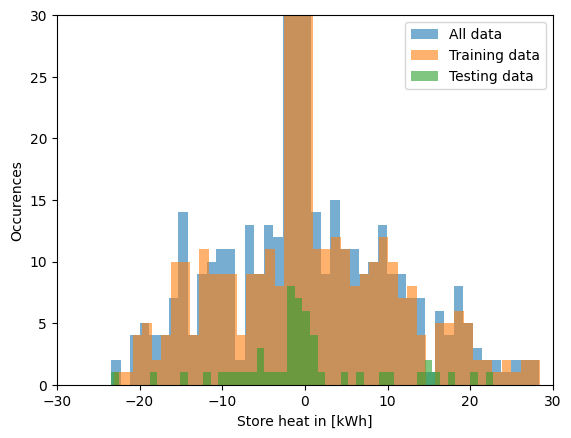

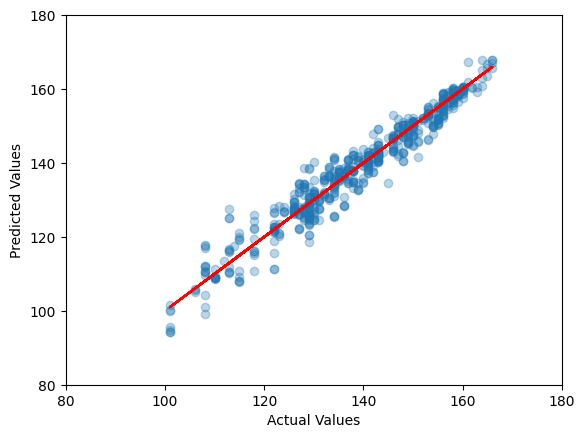

RMSE: 3.4
R-squared: 0.9
Cross-Validation RMSE: 3.6


In [4]:
X = df[[c for c in df.columns if 'initial' in c or 'store_heat_in' in c]]
y = df[[c for c in df.columns if 'final' in c]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

plt.hist(df['store_heat_in'], bins=50, label="All data", alpha=0.6)
plt.hist(X_train['store_heat_in'], bins=50, label="Training data", alpha=0.6)
plt.hist(X_test['store_heat_in'], bins=50, label="Testing data", alpha=0.6)
plt.xlabel("Store heat in [kWh]")
plt.ylabel("Occurences")
plt.xlim([-30,30])
plt.ylim([0,30])
plt.legend()
plt.show()

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([80,180])
plt.ylim([80,180])
plt.show()

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_cv_score = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"RMSE: {round(np.sqrt(abs(mse_ridge)),1)}")
print(f"R-squared: {round(r2_ridge,1)}")
print(f"Cross-Validation RMSE: {round(np.sqrt(abs(ridge_cv_score.mean())),1)}")

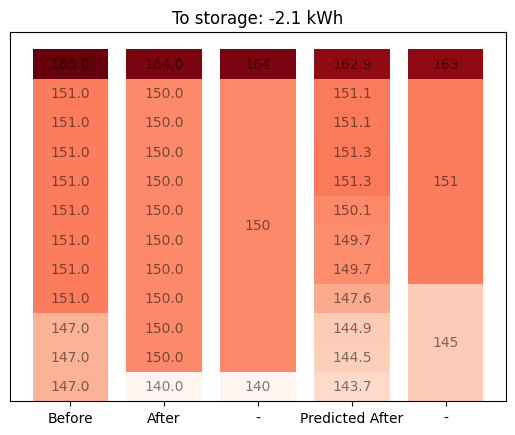

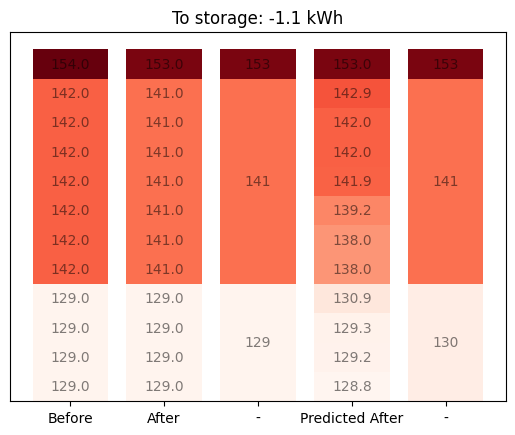

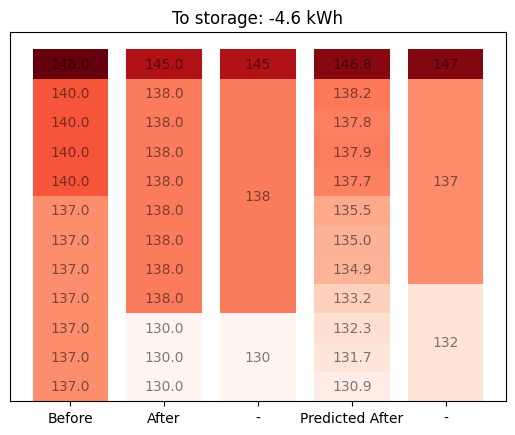

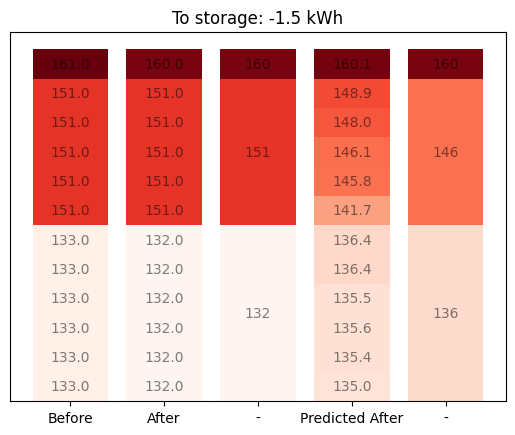

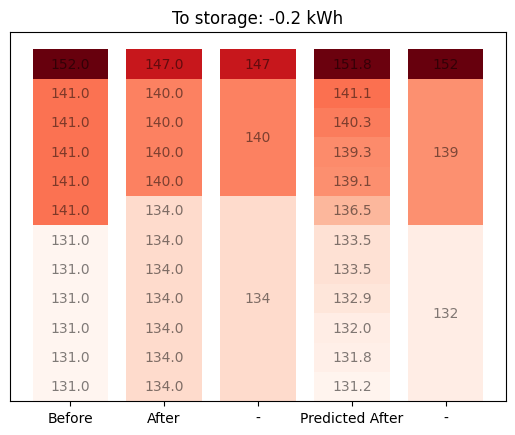

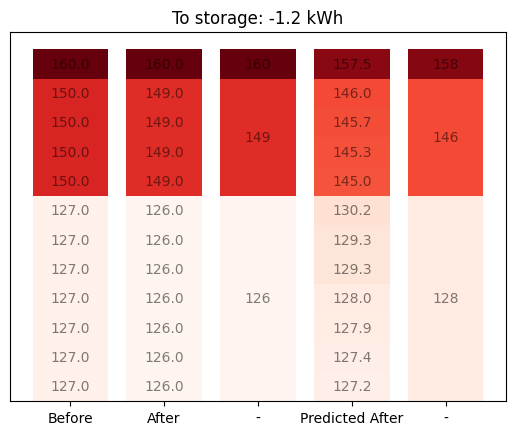

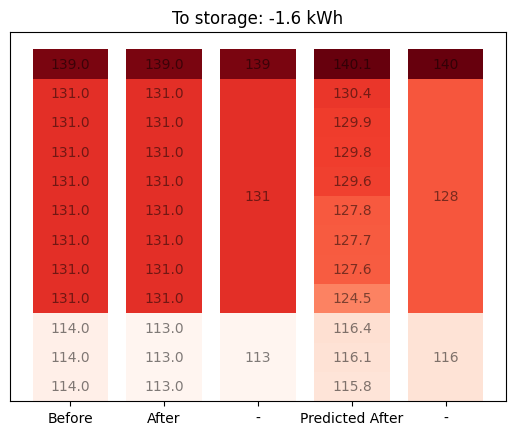

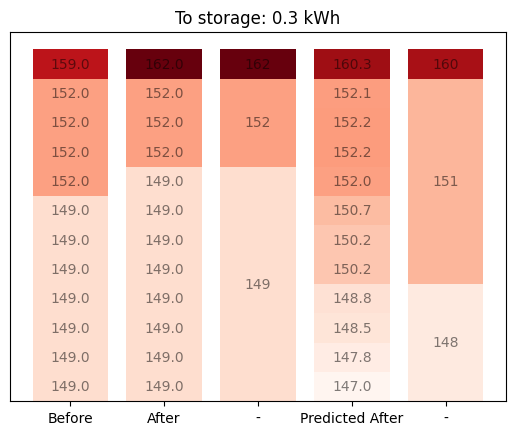

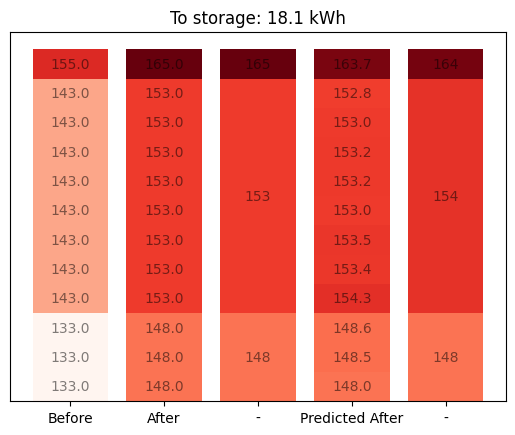

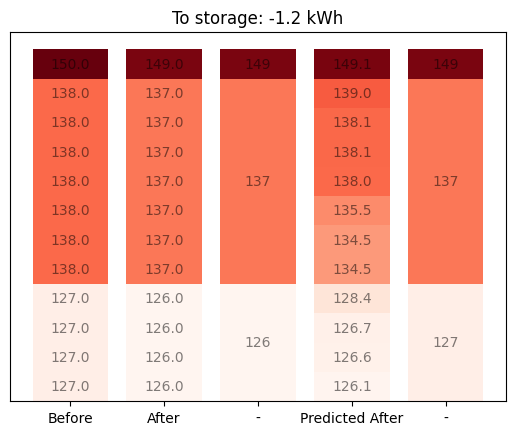

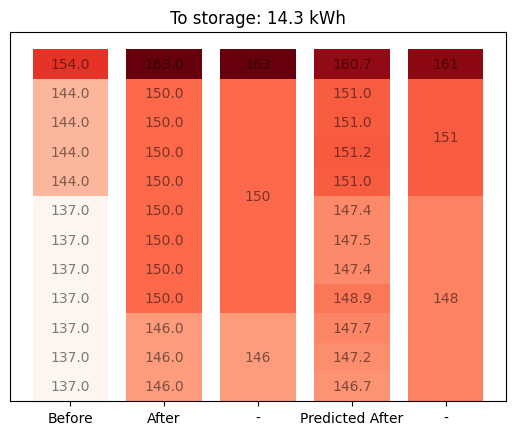

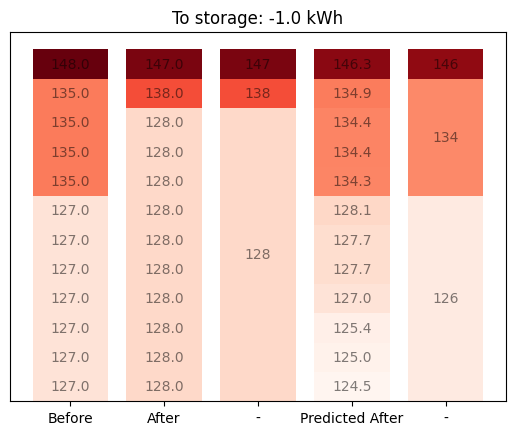

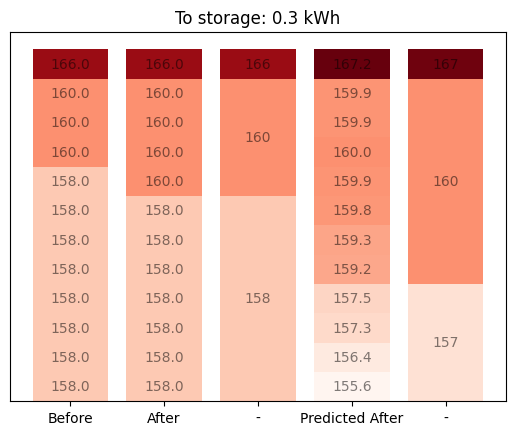

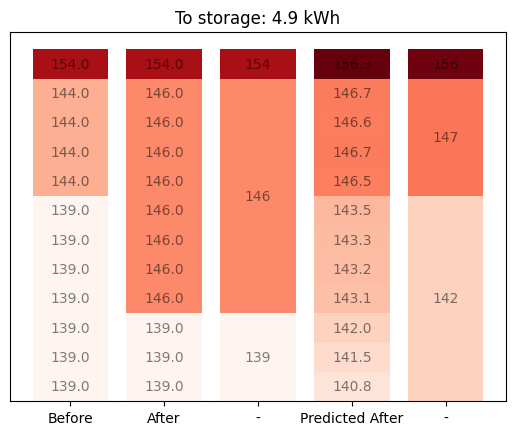

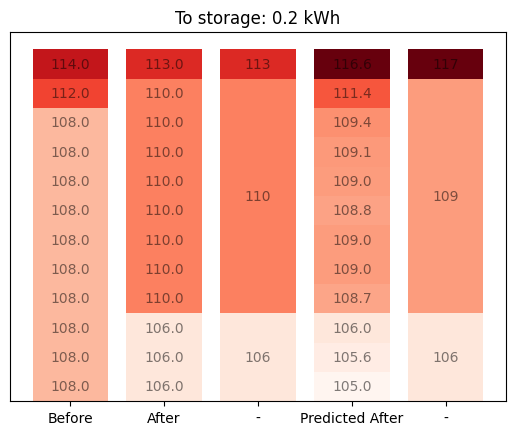

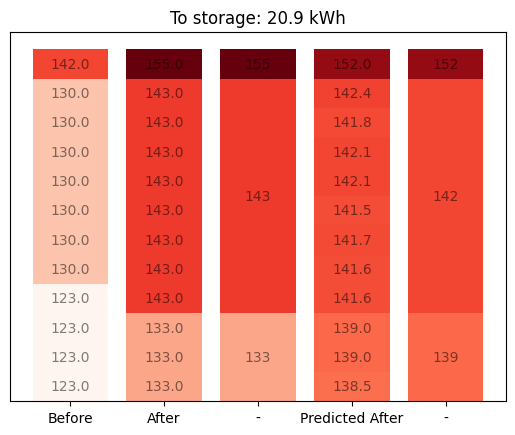

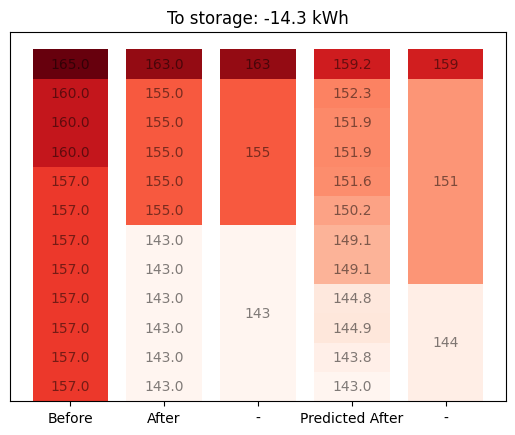

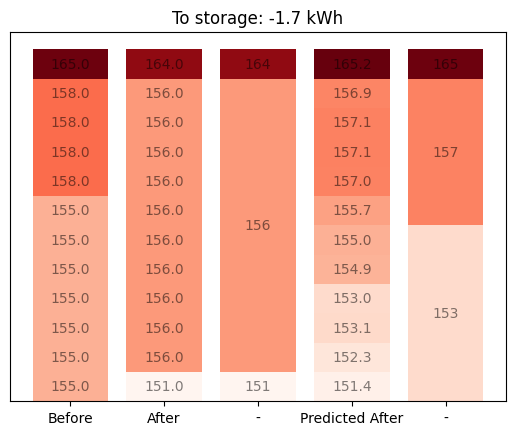

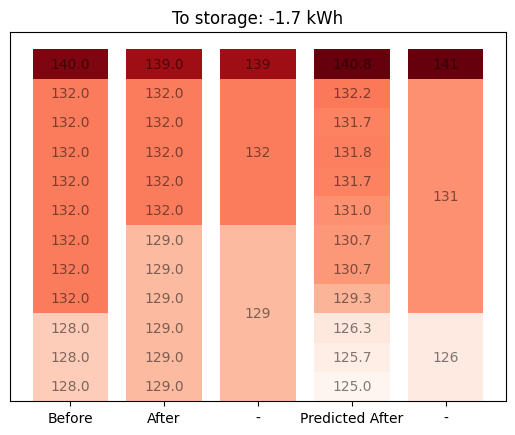

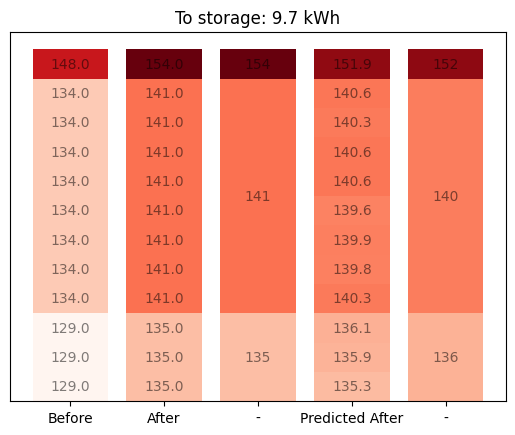

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

class TankStatePlotter():
    def __init__(self, initial, final, predicted, store_heat_in):
        self.initial = initial
        self.final = final
        self.predicted = predicted
        self.title = f"To storage: {store_heat_in} kWh"
        self.plot()

    def plot(self):
        overall_min = min(min(self.initial), min(self.final), min(self.predicted))
        overall_max = max(max(self.initial), max(self.final), max(self.predicted))
        norm = Normalize(vmin=overall_min, vmax=overall_max)
        cmap = matplotlib.colormaps['Reds'] 

        for i in range(12):
            layer_color = cmap(norm(self.initial[i]))
            plt.bar([0], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(0, 11-i+0.5, f'{self.initial[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.final[i]))
            plt.bar([1], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(1, 11-i+0.5, f'{self.final[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.predicted[i]))
            plt.bar([3], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(3, 11-i+0.5, f'{self.predicted[i]}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = model(self.final)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([2], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(2, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(2, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(2, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = model(self.predicted)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([4], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(4, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(4, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(4, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        plt.xticks([0,1,2,3,4], ['Before', 'After', '-', 'Predicted After', '-'])
        plt.yticks([])
        plt.title(self.title, fontsize=12)
        plt.show()

for i in range(20):
    print('')
    store_heat_in = X_test.iloc[i].tolist()[0]
    initial_temp = X_test.iloc[i].tolist()[1:]
    final_temp = y_test.iloc[i].tolist()
    final_temp_pred = [round(float(x),1) for x in list(y_pred_ridge[i])]
    t = TankStatePlotter(initial_temp, final_temp, final_temp_pred, store_heat_in)